In [1]:
import sys
sys.path.insert(0, "/Users/chutianwang/OneDrive/College 2025/Phys_20CL")
from utils import *

In [2]:
data = CSVexplorer("data.csv", ignoreRow = 1)
print(data.getHeader())

{0: '\ufeffVs (365.0nm)', 1: 'I (365.0nm)', 2: 'Vs (435.8nm)', 3: 'I (435.8nm)', 4: 'Vs (546.1nm)', 5: 'I (546.1nm)', 6: 'Vs (577.0nm)', 7: 'I (577.0nm)'}


In [3]:
data.convertType(range(0,8), float)
data.convertContainer(range(0,8), np.array)

In [4]:
class Experiment():
    def __init__(self, V, I, name, model = lambda v, a, b, c: a * (c - np.exp(b * v))):
        self.name = name
        self.model = model
        self.lbd = float(self.name[-8:-3]) * 1e-9
        self.V = V
        self.I = I
        self.a = None
        self.b = None
        self.c = None
        self.aerr = None
        self.berr = None
        self.cerr = None
        self.V_s = None
        self.dV_s = None
        self.fitParams = None
        
        self.fit()
        self.findV_s()
        
        self.freq = 299_792_458 / self.lbd
        self.dfreq = 1e-10 * 299_792_458 / self.lbd ** 2
        
    def fit(self):
        Ierr = np.full(self.I.size, 1e-2)
        v, cov = curve_fit(self.model, self.V, self.I, sigma = Ierr)
        self.a = v[0]
        self.b = v[1]
        self.c = v[2]
        self.aerr = cov[0][0]
        self.berr = cov[1][1]
        self.cerr = cov[1][1]
        _chisq = chisq(self.I, self.model(self.V, self.a, self.b, self.c), np.full(self.I.size, 1e-2))
        p = chi2.cdf(_chisq, self.I.size - v.size)
        self.fitParams = {"vector": v, "cov": cov, "chi2": _chisq, "p": p}
        
    def findV_s(self):
        self.V_s = np.log(self.c)/self.b
        
        dI = 1e-11 * 1/(-self.a * self.b * self.c) # I = 0, dI = dV_s/dI (0) * 1e-11
        da = 0
        db = self.berr * (-np.log(self.c) / self.b ** 2)
        dc = self.cerr * (self.a / (self.a * self.b * self.c))
        self.dV_s = (dI ** 2 + da ** 2 + db ** 2 + dc ** 2) ** 0.5
    
    def plot(self, nx, color = 0):
        setAx(nx)
        nx.set_xlabel(r"$V_s$ (V)")
        nx.set_ylabel(r"$I$ (nA)")
        nx.errorbar(self.V, self.I, xerr = 1e-3, yerr = 1e-2,
                   fmt = 'o', capsize = 3, color = colors[color],
                   label = "V, I characteristic @ " + self.name, zorder = 0)
        chi2Val, p = self.fitParams["chi2"], self.fitParams["p"]
        nx.plot(self.V, self.model(self.V, self.a, self.b, self.c), color = colors[color], zorder = 1,
               label = fr"exponential fit, $\chi^2={{{chi2Val:.0f}}}$, $p={{{p:.1f}}}$")
        nx.errorbar(self.V_s, 0, xerr = self.dV_s, fmt = 'o', capsize = 5, color = 'b', zorder = 2,
                   label = fr"extrapolated $V_{{S0}}={round(self.V_s, -int(np.floor(np.log10(abs(self.dV_s)))))}\pm{self.dV_s:.1g}$ V")
        nx.legend()

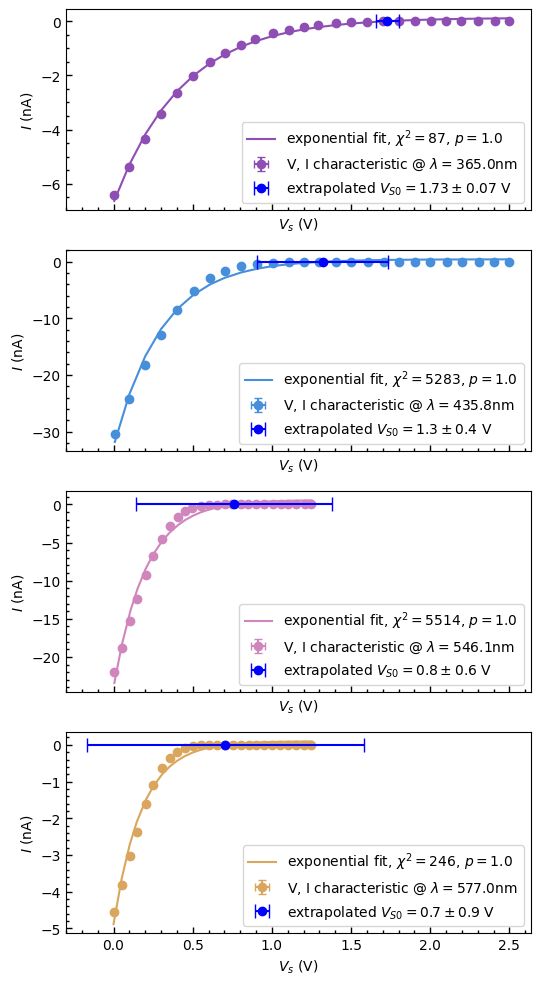

In [5]:
allGroups = [
    Experiment(data["\ufeffVs (365.0nm)"], data["I (365.0nm)"], name = r"$\lambda=365.0$nm"),
    Experiment(data["Vs (435.8nm)"], data["I (435.8nm)"], name = r"$\lambda=435.8$nm"),
    Experiment(data["Vs (546.1nm)"], data["I (546.1nm)"], name = r"$\lambda=546.1$nm"),
    Experiment(data["Vs (577.0nm)"], data["I (577.0nm)"], name = r"$\lambda=577.0$nm"),
]

fig, axes = plt.subplots(4, 1, figsize = (6, 12), sharex = True)

V_s = np.zeros(4)
dV_s = np.zeros(4)
freq = np.zeros(4)
dfreq = np.zeros(4)

for i, group in enumerate(allGroups):
    group.plot(axes[i], color = i)
    V_s[i] = group.V_s
    dV_s[i] = group.dV_s
    freq[i] = group.freq
    dfreq[i] = group.dfreq

chi2: 0.005648523204569073
p: 0.0028202771274345754


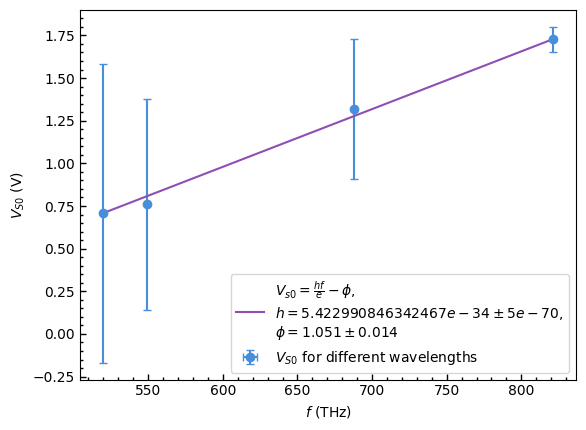

In [6]:
fig, ax = plt.subplots()
setAx(ax)
ax.set_xlabel(r"$f$ (THz)")
ax.set_ylabel(r"$V_{S0}$ (V)")

ax.errorbar(freq / 1e12, V_s, xerr = dfreq / 1e12, yerr = dV_s, fmt = 'o', capsize = 3, color = colors[1],
           label = r"$V_{S0}$ for different wavelengths")

_e = 1.60217663e-19

Vmodel = lambda f, h, phi: h * f / _e - phi
v, cov = curve_fit(Vmodel, freq, V_s, sigma = dV_s)

chi2Val = chisq(V_s, Vmodel(freq, v[0], v[1]), dV_s)
pChi2 = chi2.cdf(chi2Val, V_s.size - 2)

print("chi2:",chi2Val)
print("p:",pChi2)

ax.plot(freq / 1e12, Vmodel(freq, v[0], v[1]), color = colors[0],
label = fr"""$V_{{s0}}=\frac{{hf}}{{e}}-\phi$,
$h = {round(v[0], -int(np.floor(np.log10(abs(cov[0][0])))))}\pm{cov[0][0]:.1g}$,
$\phi = {round(v[1], -int(np.floor(np.log10(abs(cov[1][1]))-1)))}\pm{cov[1][1]:.2g}$""")

ax.legend()